# Particle Identification

In [14]:
import pickle

import numpy as np
from matplotlib import pyplot as plt
from texat.detector.micromegas import STRIP_HEIGHT
from texat.units import units as u

## Beam Tracks

The majority of signals formed in the MicroMeGaS belong to charge clusters liberated by the passage of {math}`{}^{10}\mathrm{C}` beam ions within the TPC. Given the linear response between the signal formed on the anode and the energy deposited by the beam, it is possible to correlate the energy loss curve of the central MicroMeGaS pads region with a known stopping power curve of {math}`{}^{10}\mathrm{C}` within the TPC gas mixture. 

A 2D histogram of the measured charge against the pad row was computed across all events (see {numref}`stopping-power-beam-hist`). Superimposed over this distribution is the stopping power for the beam ions in the active target, indicated by the dashed line, as simulated by SRIM.{cite:ps}`ziegler_srim_2010` There are two loci clearly visible within the histogram, one of which lies at much lower charges than the other. The primary locus, that of the beam, coincides with the predicted stopping power curve, which has been displaced along the {math}`y` axis in order to treat the initial beam energy as an unknown. The Bragg peak, corresponding to the maximum stopping power of the {math}`{}^{10}\mathrm{C}` ions, is indicated by the dotted line at row ~60. It follows that the beam is fully stopped in the active target, and any hits measured in the central silicon detectors originate from lighter particles which have sufficient energy to escape the chamber. The secondary locus, at near constant charge of 1500 units, corresponds to the scattered light alpha-particles and {math}`{}^{10}\mathrm{C}` ions produced by reactions before the sensitive region of the MicroMeGaS anode. In the far pads region, around pad 120, there is a visible low-charge discontinuity. This occurs due to the high-gain pads region located in the last 16 rows of pads. These pads are sensitive to both {math}`180^\circ`-scattered alpha particles and low stopping-power protons. Meanwhile, the beam is fully stopped well before this region.

By approximately fitting the stopping power curve to the arbitrary charge units seen in {numref}`stopping-power-beam-hist`, a rudimentary calibration of the MicroMeGaS gain can be achieved yielding {math}`\sim 1.219\times10^{-1}\,\mathrm{keV}\mathrm{cm}^{-1}` in the low-gain region.

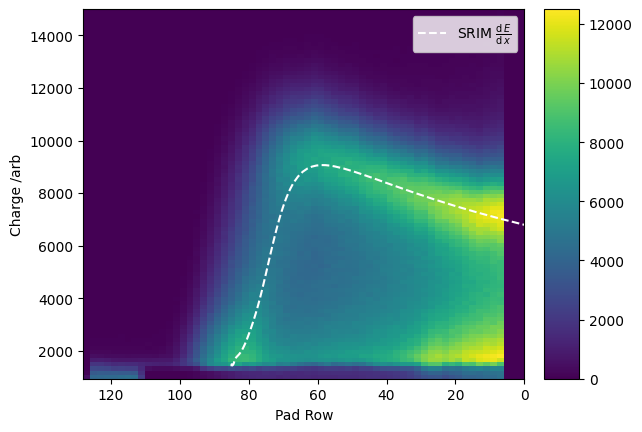

In [76]:
range_10c, de_dx_10c, ion_energy_10c = np.loadtxt(
    "data/10C-in-4He-CO2.csv", delimiter=",", unpack=True
)
range_10c = u.Quantity(range_10c, "cm")
de_dx_10c = u.Quantity(de_dx_10c, "MeV/cm")
ion_energy_10c = u.Quantity(ion_energy_10c, "MeV")

DE_DX_TO_CHARGE = 8.2 * u("cm/keV")
de_predicted = de_dx_10c.to("keV/cm") * DE_DX_TO_CHARGE  # e4
x_predicted = -43 + 128 - (range_10c.to("mm").magnitude / STRIP_HEIGHT)

with open("data/de-dx-beam.pickle", "rb") as f:
    dE_dx_hist = pickle.load(f)

dE_dx_hist[:, 1000j:15000j].plot2d()
plt.plot(
    x_predicted,
    de_predicted,
    linestyle="--",
    color="white",
    label=r"SRIM $\frac{\mathrm{d}\,E}{\mathrm{d}\,x}$",
)
plt.axhline(61, linestyle=":", color="white")
plt.legend();

## Separating Light-Product Tracks

The primary set of particles observed in the TPC are {math}`{}^{10}\mathrm{C}`, {math}`{}^{1}\mathrm{H}`, and {math}`{}^{4}\mathrm{He}`. Each has a characteristic stopping power curve, as determined by SRIM (see {numref}`stopping-power-ions`). Notably, the protons are easily distinguished from the beam ions, which typically vary by 1–2 orders of magnitude over the active region of the MicroMeGaS. Meanwhile, the stopping power of the {math}`{}^4\mathrm{He}` ions lies nearly equidistant from the other two ions (in log space), and if the ion energies are not known, experimental uncertainty can render it difficult to distinguish between the two ions simply from the energy deposition within the TPC.

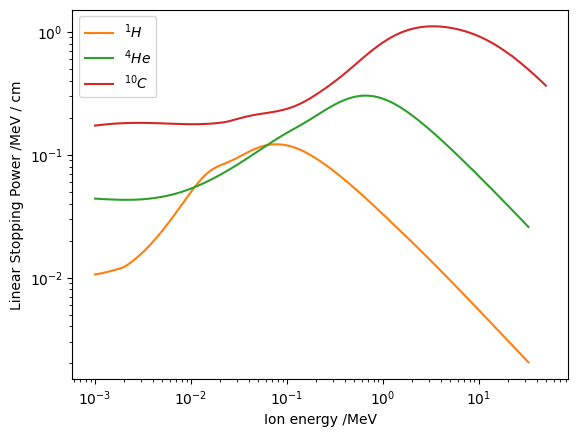

In [18]:
_, de_dx_4he, ion_energy_4he = np.loadtxt(
    "data/4He-in-4He-CO2.csv", delimiter=",", unpack=True
)

de_dx_4he = u.Quantity(de_dx_4he, "MeV/cm")
ion_energy_4he = u.Quantity(ion_energy_4he, "MeV")

_, de_dx_1h, ion_energy_1h = np.loadtxt(
    "data/1H-in-4He-CO2.csv", delimiter=",", unpack=True
)
de_dx_1h = u.Quantity(de_dx_1h, "MeV/cm")
ion_energy_1h = u.Quantity(ion_energy_1h, "MeV")

plt.figure()
plt.loglog(ion_energy_1h, de_dx_1h, "C1", label="${}^{1}H$")
plt.loglog(ion_energy_4he, de_dx_4he, "C2", label="${}^{4}He$")
plt.loglog(ion_energy_10c, de_dx_10c, "C3", label="${}^{10}C$")
plt.xlabel(f"Ion energy /{ion_energy_10c.units:~}")
plt.ylabel(f"Linear Stopping Power /{de_dx_10c.units:~}")
plt.legend();

In order to identify the ions that comprise the tracks found in {ref}`content:texat-track-fitting`, the MicroMeGas was used in tandem with the silicon detector array to establish a particle telescope (see {numref}`particle-telescope`). Conventionally, a particle telescope is established with two silicon detectors placed in close succession. In the TexAT detector, only a single "thick" silicon array was available (and chosen to prevent punch-through of the alpha particles). Therefore, in order to establish the {math}`\Delta E` component of the telescope, the MicroMeGas itself was used. Following from {eq}`bethe-bloch-formula-non-rel`, the energy deposited by an ion within the active region of the MicroMeGaS is approximately proportional to {math}`\frac{1}{E}`, such that a plot of the measured energy {math}`E` against the charge deposited within the final region of the MicroMeGaS should yield a locus unique to the {math}`z` of the ion. A series of histograms plotting these two quantities for each silicon detector (and the associated region of the MicroMeGaS) were produced, and clearly demonstrate such a phenomenon. See {numref}`de-dx-silicon-sample` for an example of such a histogram.

:::{figure} image/particle-telescope.svg
:name: particle-telescope
:width: 400px
:align: center

Illustration of a particle telescope. A thin {math}`\Delta E` detector measures the {math}`z`-dependent energy loss of the incident radiation within a thin silicon target. The ion punches through this material, and is fully stopped within the "thick" silicon detector. Conventionally, the energy lost in both detectors is taken to be the total energy of the particle. However, to first approximation the contribution lost in the thin detector can be ignored.
:::

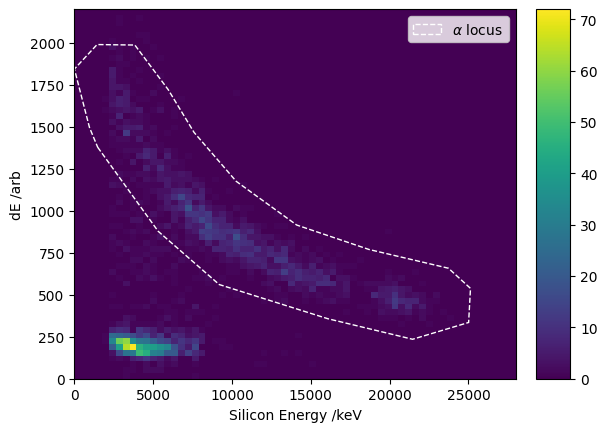

In [77]:
with open("data/de-dx-silicon.pickle", "rb") as f:
    de_dx_silicon_hist = pickle.load(f)
with open("data/gate.pickle", "rb") as f:
    vertices = pickle.load(f)
de_dx_silicon_hist[5, ...].plot()
det_id = de_dx_silicon_hist.axes[0][5]
x, y = zip(*vertices[det_id])
plt.fill(
    x, y, facecolor="none", edgecolor="white", linestyle="--", label=r"$\alpha$ locus"
)
plt.legend()
plt.ylabel("dE /arb");

The {math}`\dv{E}{x}`—{math}`E` plot is useful in discriminating between alpha particles and the lighter protons, but is only applicable in the case that a given track interacts with the silicon detector. For any other track, it is not possible to use this approach to identify the particle. For non-backscatter events, with the track identities can be assumed by the process of elimination; identifying a vertex using the light-product track and the ideal beam axis makes it possible to partition the anode into forward and backward regions. Near co-linear tracks in the backward region (towards the ion counter) are likely to be the beam (or pile-up). Remaining tracks are highly likely to be the scattered beam ion.